In [1]:
!kaggle datasets download -d pratik2901/multiclass-weather-dataset

Dataset URL: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 93% 85.0M/91.4M [00:00<00:00, 302MB/s]
100% 91.4M/91.4M [00:00<00:00, 294MB/s]


In [2]:
%cd Dataset

/content/Dataset


In [3]:
!unzip /content/multiclass-weather-dataset.zip

Archive:  /content/multiclass-weather-dataset.zip
  inflating: Multi-class Weather Dataset/Cloudy/cloudy1.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy10.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy100.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy101.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy102.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy103.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy104.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy105.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy106.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy107.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy108.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy109.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy11.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy110.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy111.

In [4]:
# import system libs
import os
import itertools
from PIL import Image # pillow

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout,BatchNormalization

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

#Check that all libraries have been loaded
print ('modules loaded')

modules loaded


In [5]:
data_dir = "/content/Dataset/Multi-class Weather Dataset"

filepaths = []
labels = []
folds = os.listdir(data_dir) #It prints: ['Cloudy', 'Sunrise', 'Rain', 'Shine']

for fold in folds:
    fold_path= os.path.join(data_dir , fold)
    filelists = os.listdir(fold_path)

    for file in filelists:
        file_path= os.path.join(fold_path , file)

        filepaths.append(file_path)
        labels.append(fold)

#Make & concatenate series & store it in dataframe
Fseries = pd.Series(filepaths, name= "Filepaths")
Lseries = pd.Series(labels, name='Labels')

df = pd.concat([Fseries , Lseries], axis=1)
df.head()

Filepaths Labels
0  /content/Dataset/Multi-class Weather Dataset/R...   Rain
1  /content/Dataset/Multi-class Weather Dataset/R...   Rain
2  /content/Dataset/Multi-class Weather Dataset/R...   Rain
3  /content/Dataset/Multi-class Weather Dataset/R...   Rain
4  /content/Dataset/Multi-class Weather Dataset/R...   Rain

In [6]:
train_df , dummy_df = train_test_split(df , train_size=0.9 , shuffle = True ,
                                       random_state=42, stratify= df['Labels'])

valid_df , test_df = train_test_split(dummy_df , train_size=0.5 , shuffle = True ,
                                      random_state=42, stratify= dummy_df['Labels'])

In [7]:
batch_size= 16
image_size= (224,224)

gen= ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df , x_col='Filepaths' , y_col='Labels'
                                   ,class_mode='categorical', color_mode='rgb'
                                   ,shuffle=True, batch_size=batch_size
                                   ,target_size=image_size)

valid_gen = gen.flow_from_dataframe(valid_df , x_col='Filepaths' , y_col='Labels'
                                   ,class_mode='categorical', color_mode='rgb'
                                   ,shuffle=True, batch_size=batch_size
                                   ,target_size=image_size)

test_gen = gen.flow_from_dataframe(test_df , x_col='Filepaths' , y_col='Labels'
                                   ,class_mode='categorical', color_mode='rgb'
                                   ,shuffle=False, batch_size=batch_size
                                   ,target_size=image_size)

Found 1012 validated image filenames belonging to 4 classes.
Found 56 validated image filenames belonging to 4 classes.
Found 57 validated image filenames belonging to 4 classes.


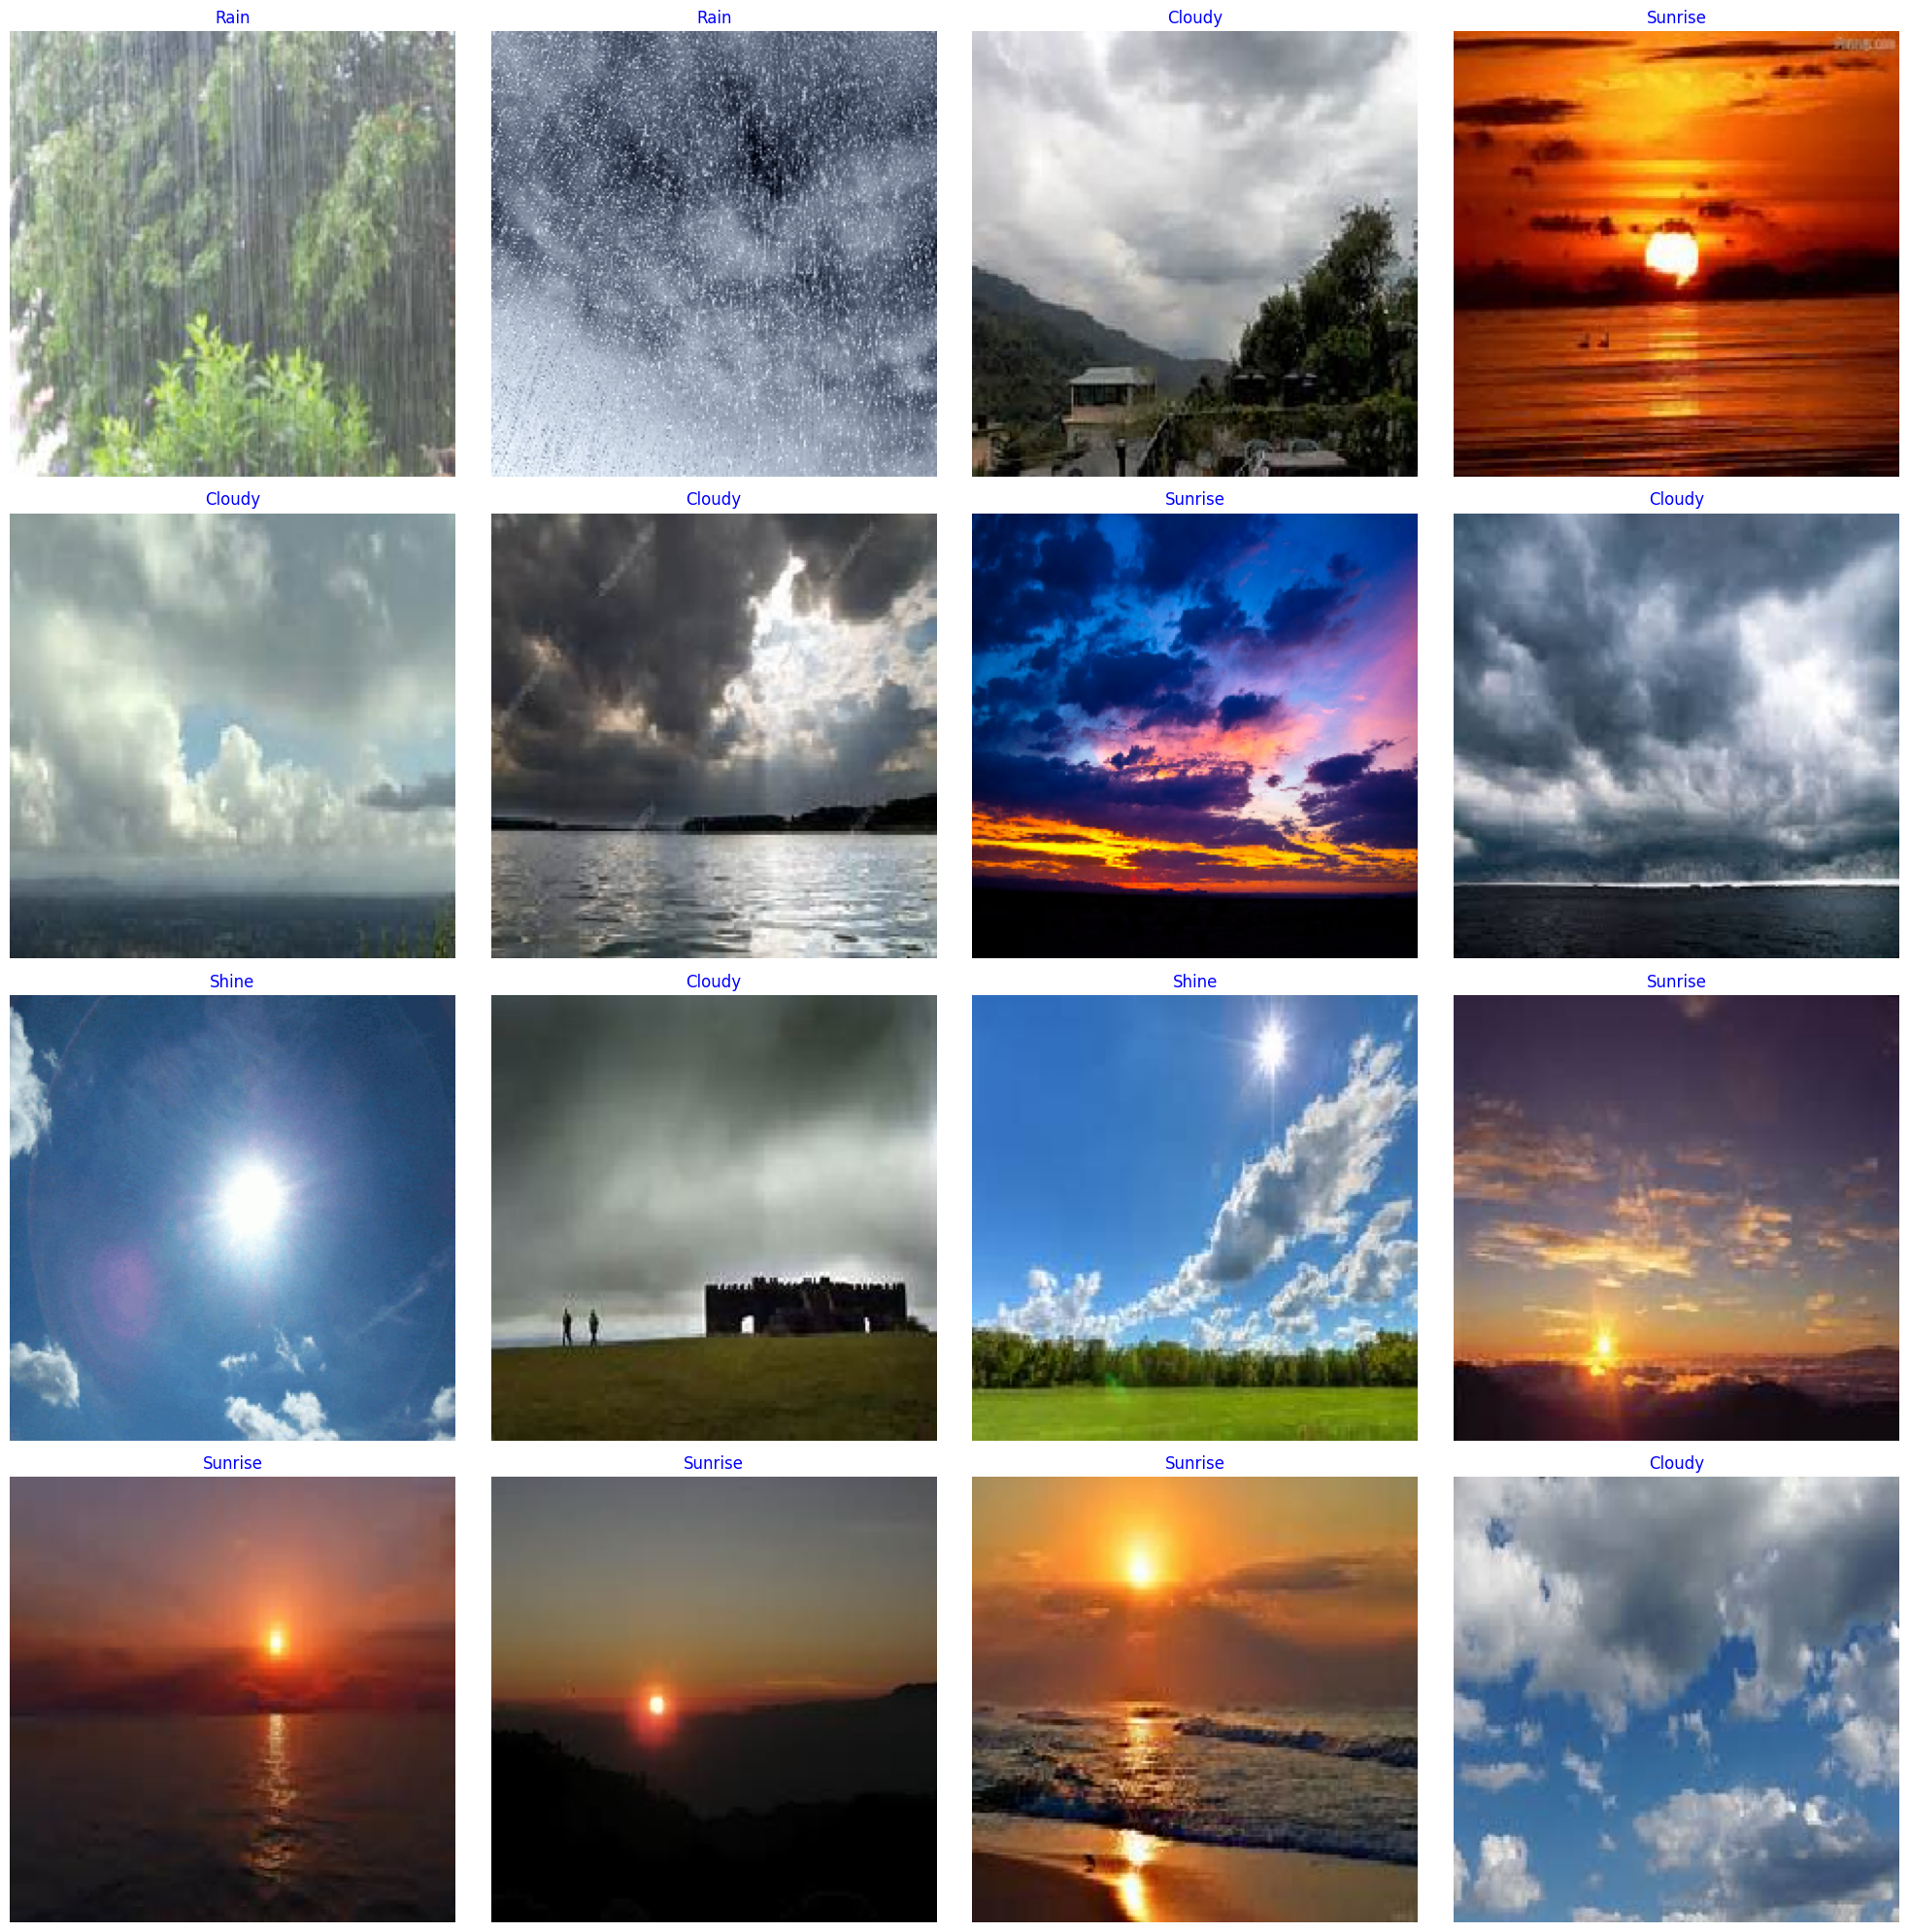

In [8]:
gen_dict = train_gen.class_indices
classes_name = list(gen_dict.keys())

images, labels = next(train_gen)


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes_name[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
channels = 3
image_shape =(image_size[0], image_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu", input_shape=image_shape),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"),
    BatchNormalization(),

    Flatten(),

    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation="softmax")
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      2

In [10]:
history = model.fit(train_gen, epochs= 16, verbose= 1,
                    validation_data = valid_gen, shuffle= False)

Epoch 1/16
64/64 [==============================] - 21s 140ms/step - loss: 7.9527 - accuracy: 0.6551 - val_loss: 45.8844 - val_accuracy: 0.3750
Epoch 2/16
64/64 [==============================] - 6s 88ms/step - loss: 2.2421 - accuracy: 0.7935 - val_loss: 0.9192 - val_accuracy: 0.7500
Epoch 3/16
64/64 [==============================] - 6s 90ms/step - loss: 1.4783 - accuracy: 0.8231 - val_loss: 0.4959 - val_accuracy: 0.8214
Epoch 4/16
64/64 [==============================] - 7s 103ms/step - loss: 0.6031 - accuracy: 0.8844 - val_loss: 0.8993 - val_accuracy: 0.8750
Epoch 5/16
64/64 [==============================] - 6s 90ms/step - loss: 0.4847 - accuracy: 0.8933 - val_loss: 0.3505 - val_accuracy: 0.8571
Epoch 6/16
64/64 [==============================] - 7s 107ms/step - loss: 0.3889 - accuracy: 0.9022 - val_loss: 0.1981 - val_accuracy: 0.8929
Epoch 7/16
64/64 [==============================] - 6s 97ms/step - loss: 0.2998 - accuracy: 0.9209 - val_loss: 0.2257 - val_accuracy: 0.8929
Epoch 8/

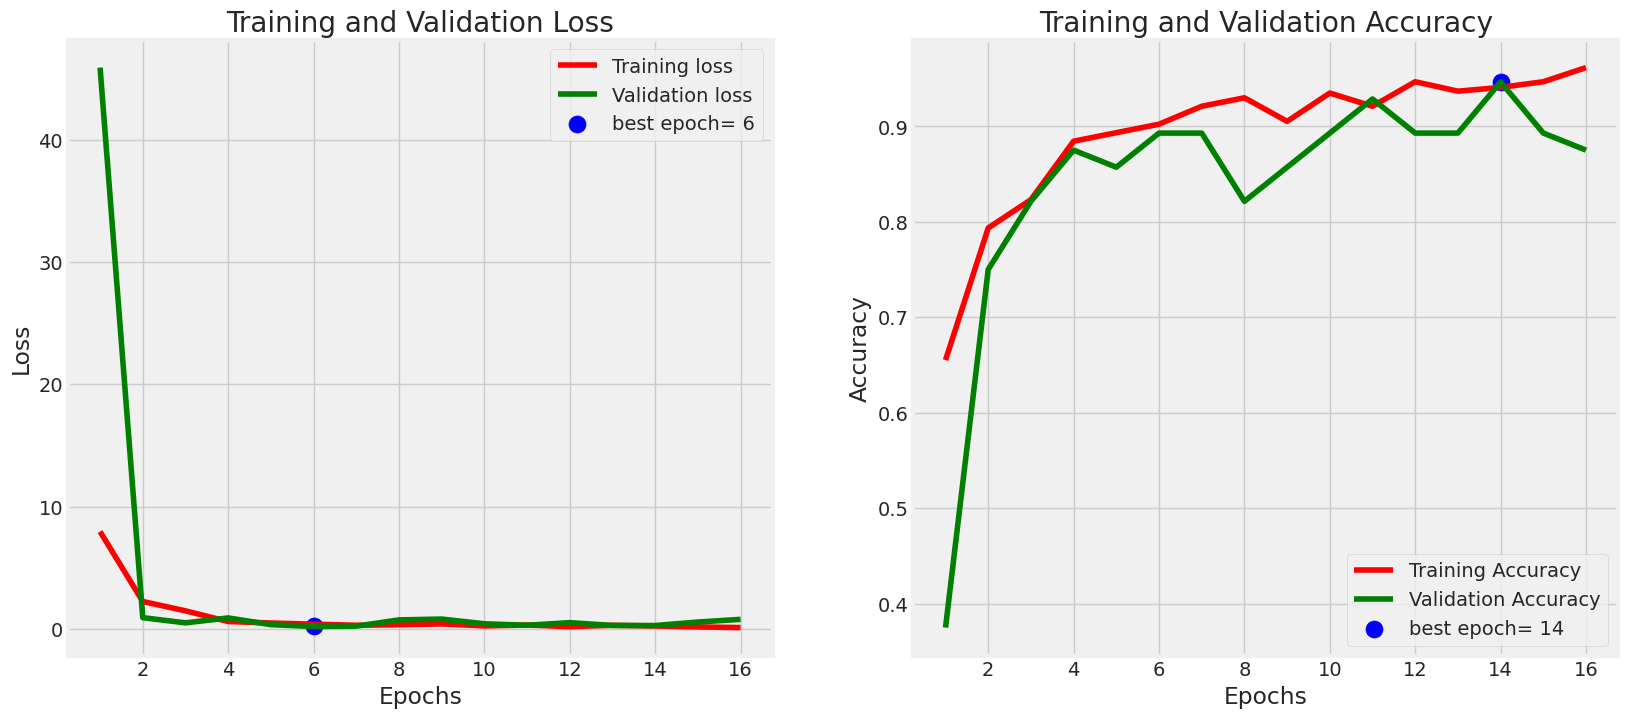

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [12]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

4/4 [==============================] - 1s 256ms/step - loss: 1.3180 - accuracy: 0.8421
Train Loss:  0.17845609784126282
Train Accuracy:  0.9387351870536804
--------------------
Validation Loss:  0.782565176486969
Validation Accuracy:  0.875
--------------------
Test Loss:  1.3179984092712402
Test Accuracy:  0.8421052694320679


In [13]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

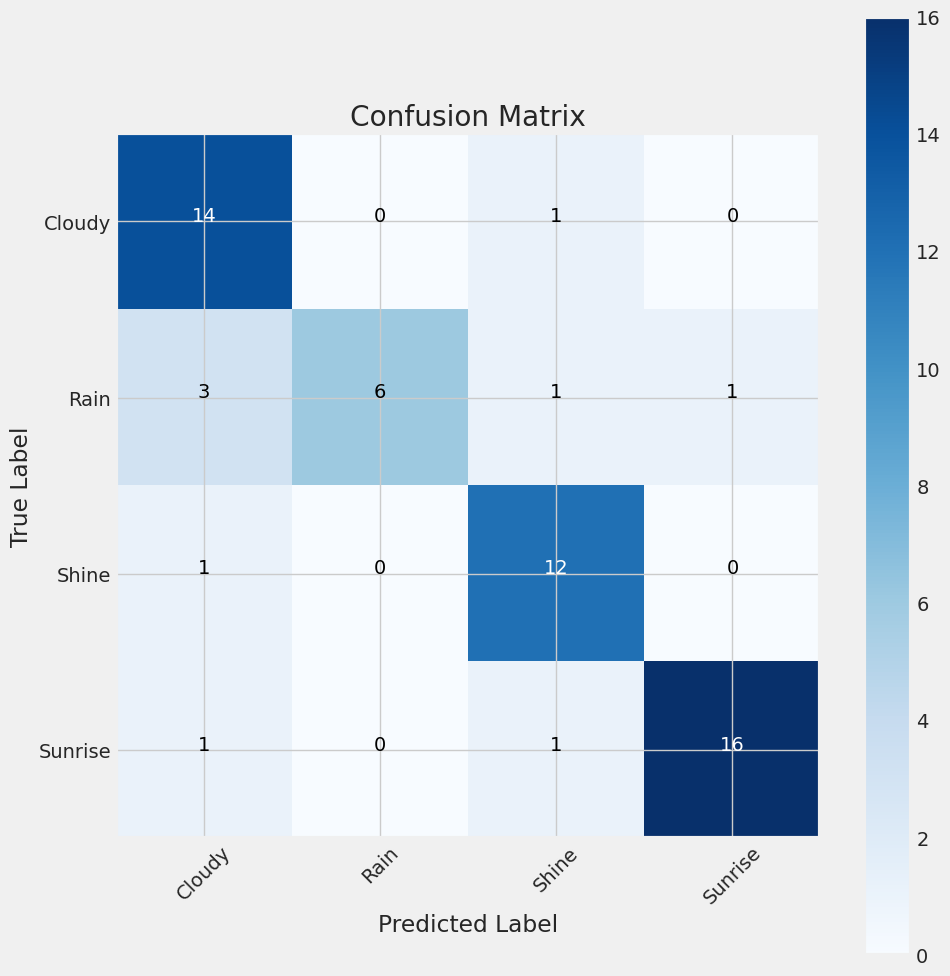

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center',
             color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [15]:
# Classification report
print(classification_report(test_gen.classes, y_pred,
                            target_names= classes))

              precision    recall  f1-score   support

      Cloudy       0.74      0.93      0.82        15
        Rain       1.00      0.55      0.71        11
       Shine       0.80      0.92      0.86        13
     Sunrise       0.94      0.89      0.91        18

    accuracy                           0.84        57
   macro avg       0.87      0.82      0.83        57
weighted avg       0.87      0.84      0.84        57



In [16]:
model.save('Weather.h5')

In [17]:
loaded_model = tf.keras.models.load_model('/content/Dataset/Weather.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy',
                     metrics= ['accuracy'])

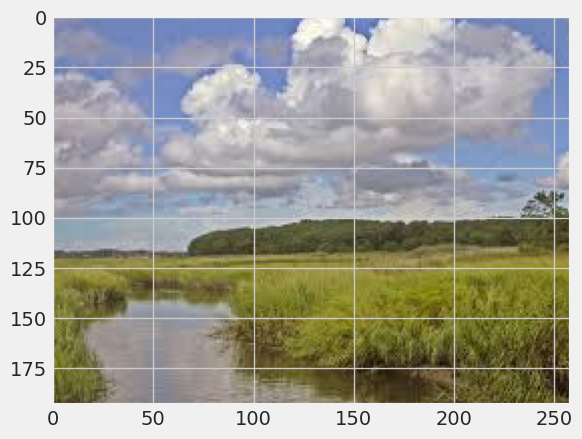

In [23]:
image_path = '/content/Dataset/Multi-class Weather Dataset/Cloudy/cloudy100.jpg'
image = Image.open(image_path)
plt.imshow(image)

In [19]:
# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

In [20]:
# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
print(f"{class_labels[np.argmax(predictions)]}")

1/1 [==============================] - 1s 718ms/step
Cloudy
